In [78]:
cd ../..

/Users/joeranbosma/stack


In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import matplotlib.pyplot as plt

# own imports
from evaluation import Referee, load_data, select_dates, select_day_nums
from train import (BatchCreator, Logger, plot_confidence_series, plot_some_confidence_intervals, 
                   prepare_training, perform_training_scheme)
from model_builder import (get_pinball_losses, get_simple_dense_model, get_simple_dist_model,
                           get_variable_dist_model, get_direct_dist_model)
from flow import (model_predict, denorm_preds, warp_preds_to_ref_form, plot_some, evaluate_model, 
                  save_object, load_object)
from preprocess import (preprocess, get_features, pandas_cat_data, reset_categorical_features, 
                        read_and_preprocess_data)


# Setup file paths
data_dir = 'data/'
os.environ['DATA_DIR'] = data_dir
sub_dir = 'submissions_uncertainty/'
model_dir = 'models/uncertainty/train_multiple_levels_lag/'
plt.rcParams['font.size'] = 13

# Hardcode requested quantiles
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

# Lag performance

In [24]:
def transform_experiment_results_lag(model_dir):
    ls = []
    
    for lag in [3, 28]:
        fn_base = model_dir + f"level_9/lag_{lag}/level9_{lag}_"
        m1, m2, m3 = [load_object(fn_base + f"part{i}_metrics.pickle") for i in range(1, 1+3)]
        
        labels = ['part1', 'part2', 'part3']
        for metrics, label in zip([m1, m2, m3], labels):
            lags = [1, 2, 3] if lag == 3 else [7, 14, 21, 28]
            
            for m, real_lag in zip(metrics, np.tile(lags, reps=9)):
                score = m['WSPL']
                level = list(m.keys())[0]
                ls += [[level, real_lag, label, score]]
    
    df = pd.DataFrame(ls, columns=['level', 'lag', 'part', 'WSPL'])
    return df

def transform_experiment_results_lag_try2(model_dir):
    ls = []
    
    for lag in [28]:
        fn_base = model_dir + f"level_9/lag_{lag}/level9_{lag}_"
        m1, m2, m3 = [load_object(fn_base + f"part{i}_metrics.pickle") for i in range(1, 1+3)]
        
        labels = ['part1', 'part2', 'part3']
        for metrics, label in zip([m1, m2, m3], labels):
            lags = [1, 2, 3, 7, 14, 21, 28]
            
            for m, real_lag in zip(metrics, np.tile(lags, reps=9)):
                score = m['WSPL']
                level = list(m.keys())[0]
                ls += [[level, real_lag, label, score]]
    
    df = pd.DataFrame(ls, columns=['level', 'lag', 'part', 'WSPL'])
    return df


df = transform_experiment_results_lag(model_dir)
df2 = transform_experiment_results_lag_try2(model_dir + "try2/")

In [29]:
# results_prev = pd.concat((df1, df2, df3))
results = df
results_duplo = df2
results

,level,lag,part,WSPL
0,1,1,part1,0.065123
1,1,2,part1,0.057985
2,1,3,part1,0.429619
3,2,1,part1,0.099662
4,2,2,part1,0.102464
...,...,...,...,...
184,8,28,part3,0.124557
185,9,7,part3,0.147300
186,9,14,part3,0.143321
187,9,21,part3,0.147927


In [31]:
results_duplo.head(16)

,level,lag,part,WSPL
0,1,1,part1,0.197478
1,1,2,part1,0.095521
2,1,3,part1,0.075939
3,1,7,part1,0.073670
4,1,14,part1,0.144621
5,1,21,part1,0.188305
6,1,28,part1,0.080501
7,2,1,part1,0.103229
8,2,2,part1,0.133331
9,2,3,part1,0.105728


## Plot per level, per lag

1


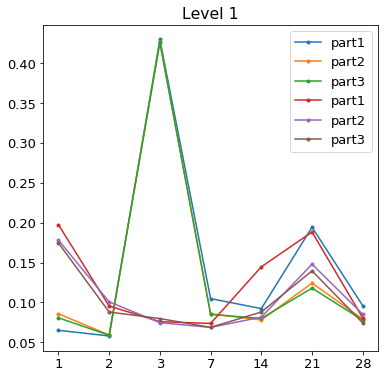

2


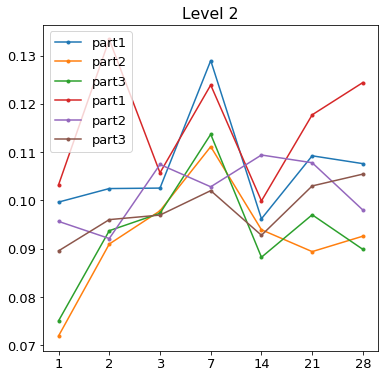

3


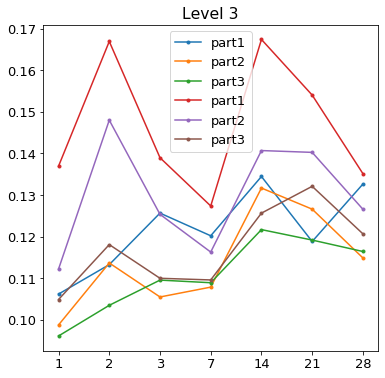

4


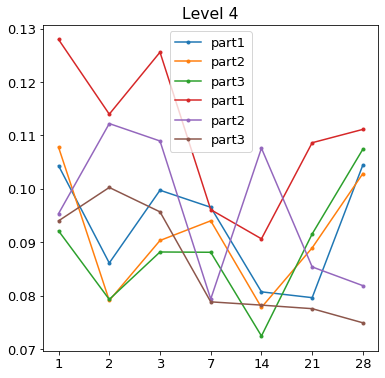

5


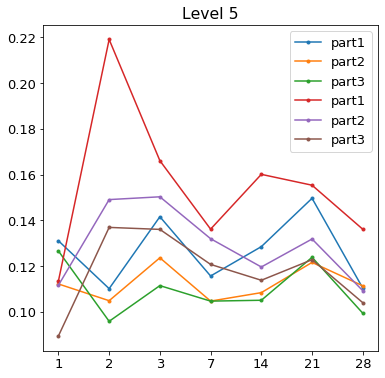

6


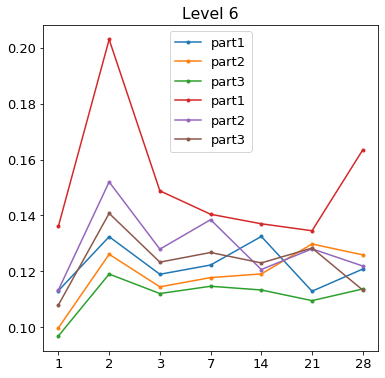

7


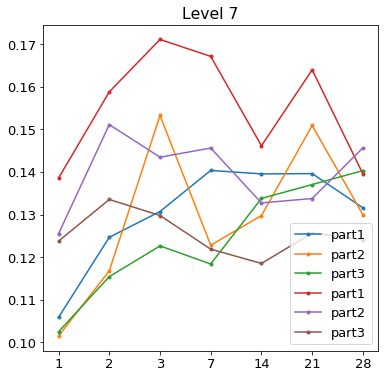

8


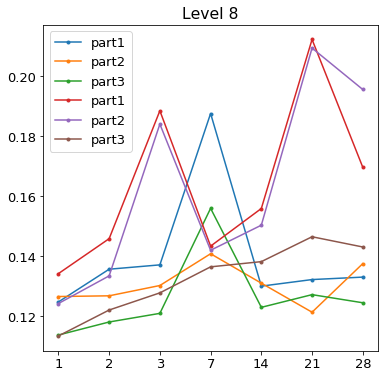

9


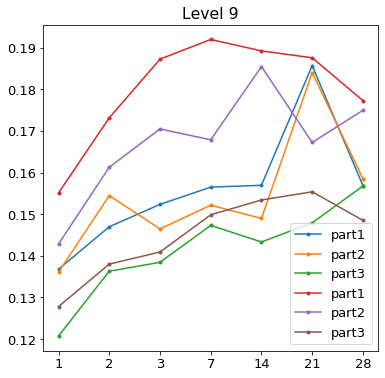

In [36]:
def plot_experiment_level(results, level, lag, alpha=1, colors=None, parts=[1, 2, 3], ax=None):
    if ax is None:
        f, ax = plt.subplots(1, 1, figsize=(18, 6))
    if colors is None:
        colors = [None for i in range(3)]
    if not isinstance(colors, list):
        colors = [colors for i in range(3)]
    
    # select level
    df = results[(results.level == level)]
    labels = df.lag.unique()
    for part in df.part.unique():
        df_part = df[df.part == part]
        ax.plot(range(len(labels)), df_part['WSPL'].values, '.-', alpha=alpha, label=part)
    
    #ax.set_ylim(0)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_title("Level {}".format(level))
    ax.legend()
    
    return ax

# plot performance for each layer, at each level
for level in results.level.unique():
    print(level)

    f, ax = plt.subplots(1, 1, figsize=(6, 6))

    # plot_experiment_level_layer(results_prev, layer, level, alpha=0.5, colors='k', ax=ax)
    plot_experiment_level(results, level, lag, alpha=1, ax=ax)
    plot_experiment_level(results_duplo, level, lag, alpha=1, ax=ax)

    plt.show()

## Report

In [43]:
res = pd.merge(df, df2, left_on=['level', 'lag', 'part'], right_on=['level', 'lag', 'part'], suffixes=["run1", "run2"])

In [85]:
df = res[res.part == 'part3'].groupby(['level', 'lag']).min().min(axis=1)
df = df.reset_index()
df.columns = list(df.columns)[0:2] + ['WSPL']
df

,level,lag,WSPL
0,1,1,0.080793
1,1,2,0.058875
2,1,3,0.079811
3,1,7,0.068744
4,1,14,0.080000
...,...,...,...
58,9,3,0.138442
59,9,7,0.147300
60,9,14,0.143321
61,9,21,0.147927


In [114]:
y = []
labels = []

for lag in res.lag.unique():
    labels.append(lag)
    y.append(df[df.lag == lag].groupby('level').WSPL.min().values)
labels

[1, 2, 3, 7, 14, 21, 28]

In [117]:
q = np.array(y)
q

array([[0.08079296, 0.07508037, 0.09606803, 0.09213143, 0.08947674,
        0.09678845, 0.10250704, 0.11351237, 0.12075035],
       [0.05887506, 0.0937416 , 0.1034497 , 0.07928223, 0.09588225,
        0.11897901, 0.11543325, 0.1181632 , 0.1363043 ],
       [0.07981114, 0.09697388, 0.10951454, 0.08816884, 0.1114724 ,
        0.11199388, 0.12263505, 0.12103385, 0.13844243],
       [0.06874355, 0.10203487, 0.10888402, 0.07883094, 0.10470029,
        0.11460263, 0.1183946 , 0.13650686, 0.14729983],
       [0.07999968, 0.08824725, 0.12166705, 0.07243736, 0.10507738,
        0.11326543, 0.11853036, 0.12304061, 0.14332123],
       [0.11800376, 0.09703071, 0.11915071, 0.07755187, 0.12279658,
        0.1094489 , 0.12565754, 0.12725973, 0.1479269 ],
       [0.07428965, 0.08986897, 0.11639952, 0.07490168, 0.09942279,
        0.11322617, 0.12408479, 0.12455665, 0.14851825]])

In [119]:
q[:,0] = z
q

array([[0.0605    , 0.07508037, 0.09606803, 0.09213143, 0.08947674,
        0.09678845, 0.10250704, 0.11351237, 0.12075035],
       [0.0652    , 0.0937416 , 0.1034497 , 0.07928223, 0.09588225,
        0.11897901, 0.11543325, 0.1181632 , 0.1363043 ],
       [0.0687    , 0.09697388, 0.10951454, 0.08816884, 0.1114724 ,
        0.11199388, 0.12263505, 0.12103385, 0.13844243],
       [0.0804    , 0.10203487, 0.10888402, 0.07883094, 0.10470029,
        0.11460263, 0.1183946 , 0.13650686, 0.14729983],
       [0.0595    , 0.08824725, 0.12166705, 0.07243736, 0.10507738,
        0.11326543, 0.11853036, 0.12304061, 0.14332123],
       [0.063     , 0.09703071, 0.11915071, 0.07755187, 0.12279658,
        0.1094489 , 0.12565754, 0.12725973, 0.1479269 ],
       [0.0785    , 0.08986897, 0.11639952, 0.07490168, 0.09942279,
        0.11322617, 0.12408479, 0.12455665, 0.14851825]])

In [131]:
q.shape

(7, 9)

In [134]:
m = np.mean(q, axis=1)
m.shape

(7,)

In [133]:
q2 = np.zeros((7, 10))
q2[:, :9] = q
q2[:, 9] = m
q2

array([[0.0605    , 0.07508037, 0.09606803, 0.09213143, 0.08947674,
        0.09678845, 0.10250704, 0.11351237, 0.12075035, 0.09409053],
       [0.0652    , 0.0937416 , 0.1034497 , 0.07928223, 0.09588225,
        0.11897901, 0.11543325, 0.1181632 , 0.1363043 , 0.10293728],
       [0.0687    , 0.09697388, 0.10951454, 0.08816884, 0.1114724 ,
        0.11199388, 0.12263505, 0.12103385, 0.13844243, 0.10765943],
       [0.0804    , 0.10203487, 0.10888402, 0.07883094, 0.10470029,
        0.11460263, 0.1183946 , 0.13650686, 0.14729983, 0.11018378],
       [0.0595    , 0.08824725, 0.12166705, 0.07243736, 0.10507738,
        0.11326543, 0.11853036, 0.12304061, 0.14332123, 0.10500963],
       [0.063     , 0.09703071, 0.11915071, 0.07755187, 0.12279658,
        0.1094489 , 0.12565754, 0.12725973, 0.1479269 , 0.10998033],
       [0.0785    , 0.08986897, 0.11639952, 0.07490168, 0.09942279,
        0.11322617, 0.12408479, 0.12455665, 0.14851825, 0.10771987]])

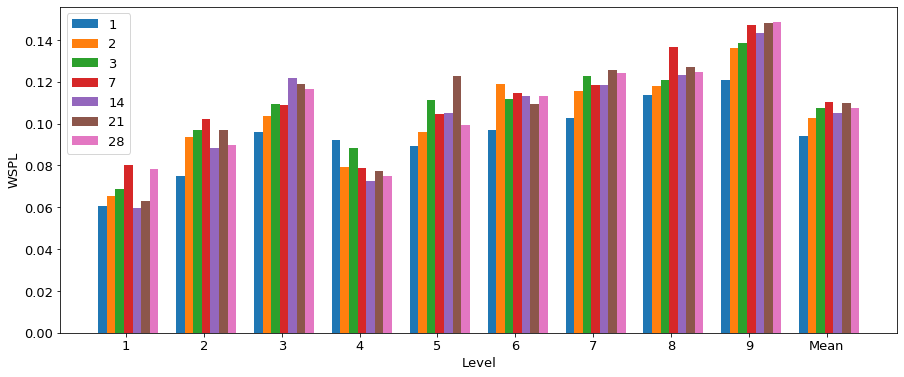

In [137]:
f, ax = plt.subplots(1, 1, figsize=(15, 6))

x = np.arange(len(q2[0]))

for i, label in enumerate(labels):
    w = 0.11
    ax.bar(x+w*i, height=q2[i], width=w, label=label)

ax.legend()
ax.set_xticks(x+0.3)
ax.set_xticklabels(list(range(1, 1+9)) + ['Mean'])
ax.set_xlabel("Level")
ax.set_ylabel("WSPL")

f.savefig("lag.pdf")
plt.show()

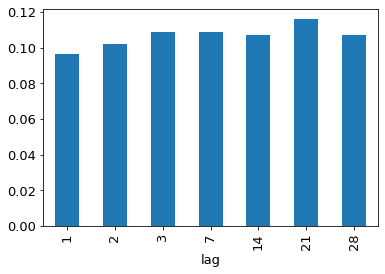

In [121]:
df.groupby('lag').mean()['WSPL'].plot(kind='bar')

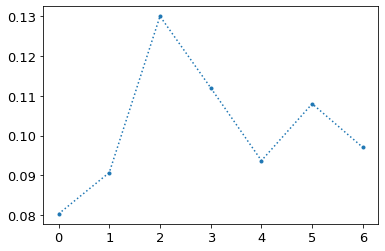

In [142]:
def find_model_WSPL(model_path, level, prediction_lag):
    # find model fn
    model_path_base = model_path + "mlp-run3"
    model_path_base += "/lag{}/".format(prediction_lag)
    
    # get list of files
    fn_list = os.listdir(model_path_base)

    model_fn_base = "level{}_stepped_lr_part3_WSPL".format(level)
    fn_list_mask = [(model_fn_base in fn) for fn in fn_list]
    
    fnames = [fn for i, fn in enumerate(fn_list) if fn_list_mask[i]]
    scores = [fn.replace(model_fn_base, "").replace('.h5', '') for fn in fnames]
    scores = [float(s) for s in scores]
    return scores

model_path = "models/uncertainty/final/"
level = 2

z = []
for prediction_lag in [28, 21, 14, 7, 3, 2, 1][::-1]:
    scores = find_model_WSPL(model_path, level, prediction_lag)
    z.append(min(scores))

plt.plot(z, '.:')

## Create table of best run, per level, per lag
For each level and each layer, select best WSPL

In [37]:
# df_a = results_prev.groupby(['level', 'layer'])['WSPL'].min()
df_b = results.groupby(['level', 'lag'])['WSPL'].min()
# df = pd.concat((df_a, df_b), axis=1)
# df.columns = ["Baseline", "With LightGBM"]
df = df_b
df

level  lag
1      1      0.065123
       2      0.057985
       3      0.425947
       7      0.084959
       14     0.078034
                ...   
9      3      0.138442
       7      0.147300
       14     0.143321
       21     0.147927
       28     0.156749
Name: WSPL, Length: 63, dtype: float64

1


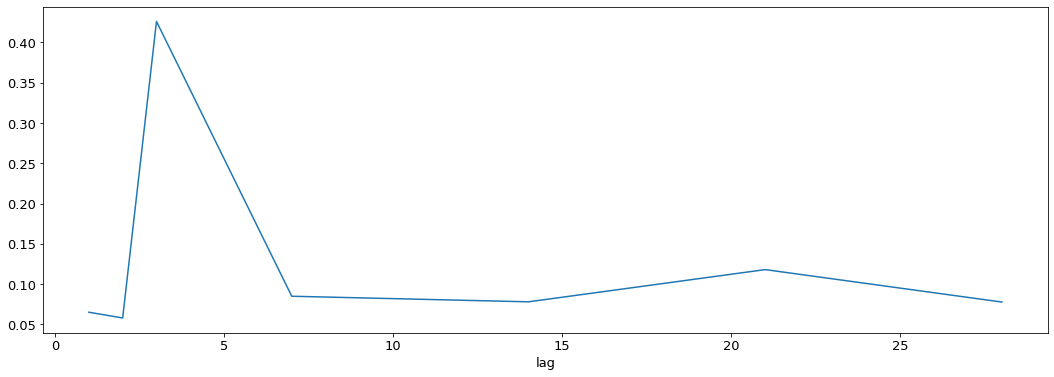

2


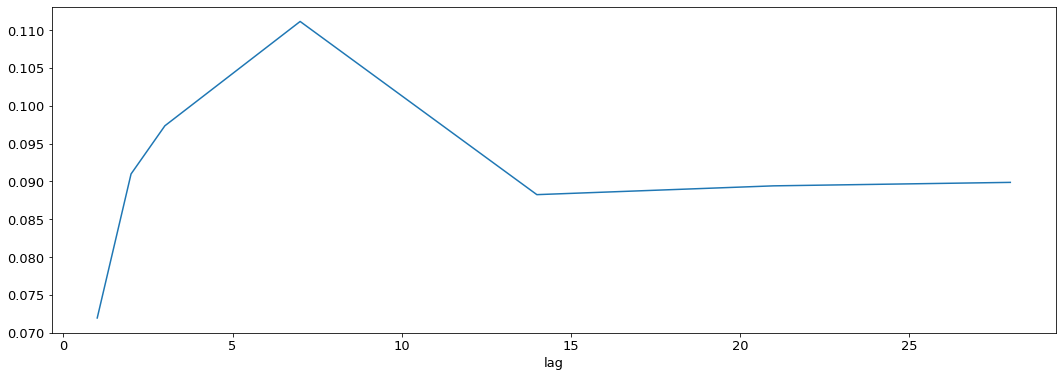

3


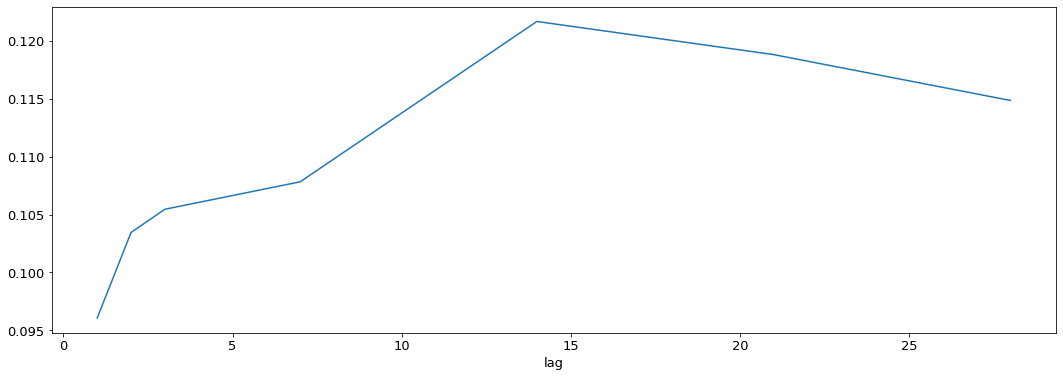

4


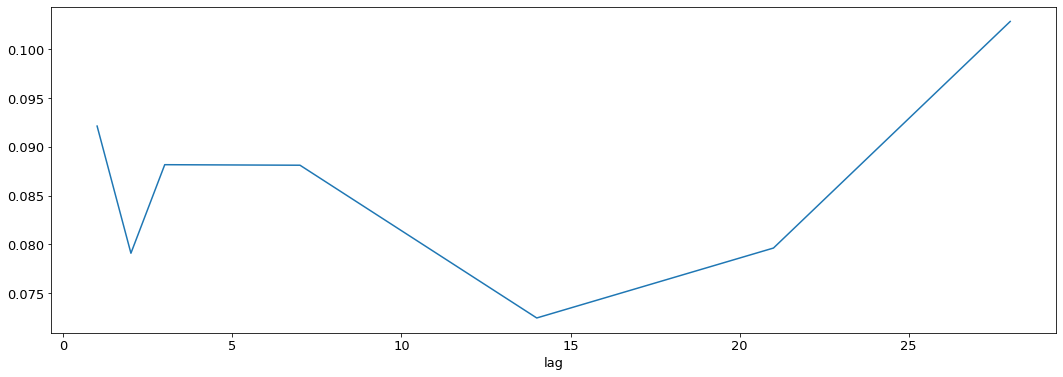

5


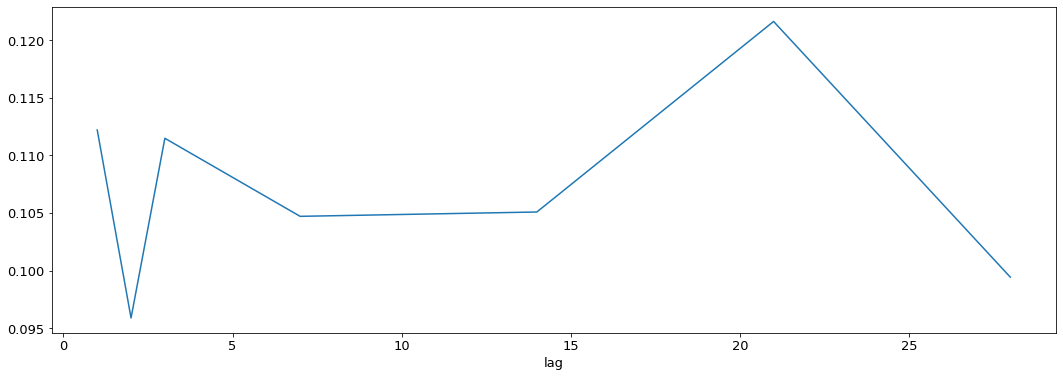

6


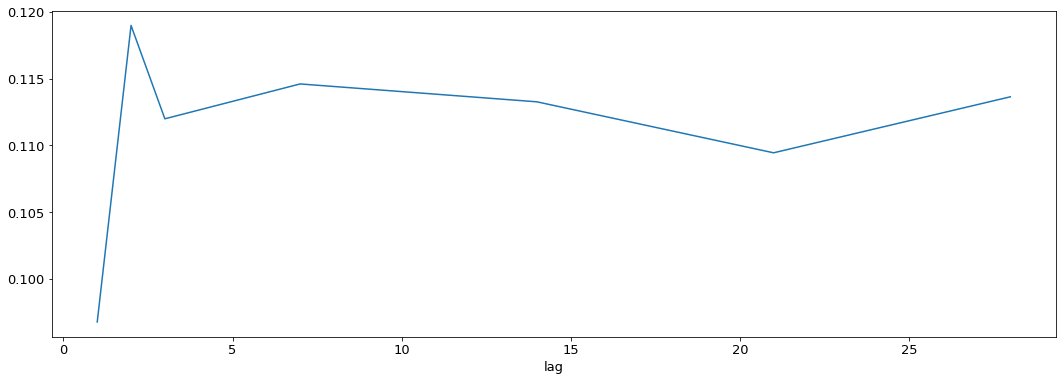

7


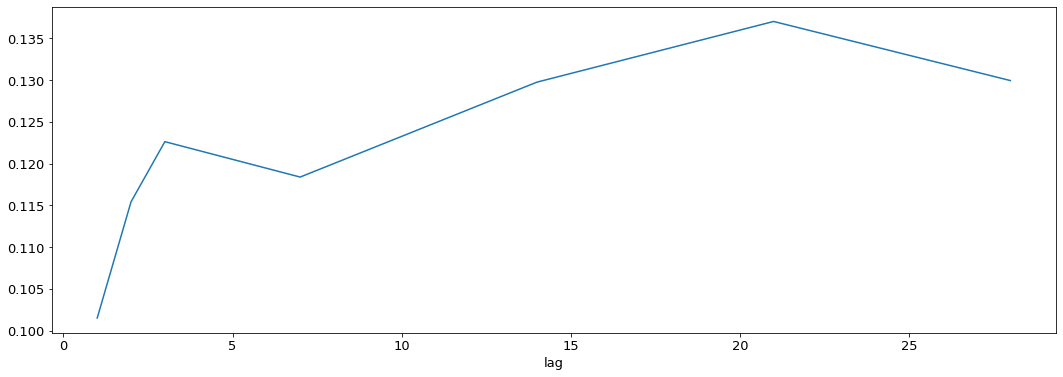

8


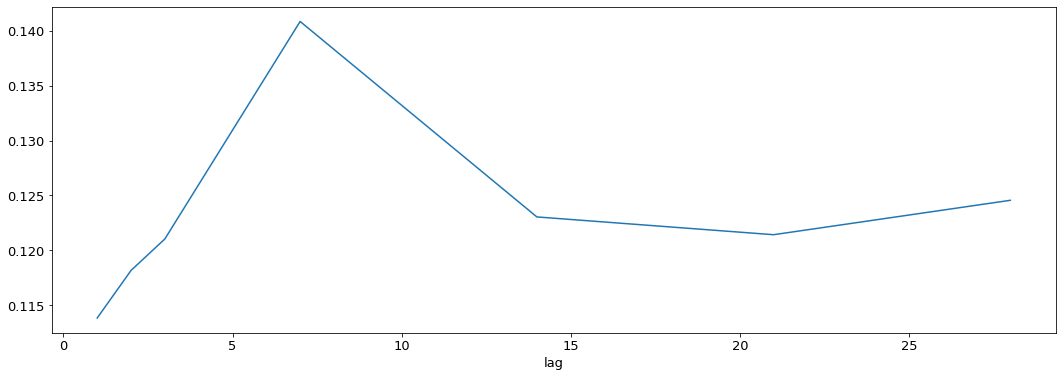

9


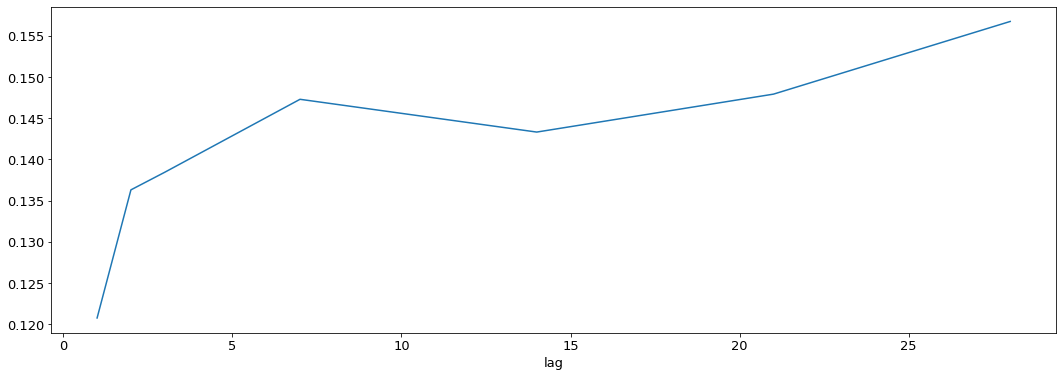

In [38]:
for level in range(1, 9+1):
    print(level)
    f, ax = plt.subplots(figsize=(18, 6))
    df.loc[level].plot(ax=ax)
    plt.show()

In [39]:
df_table = df.unstack().T
df_table

level,1,2,3,4,5,6,7,8,9
lag,,,,,,,,,
1,0.065123,0.071944,0.096068,0.092131,0.112195,0.096788,0.101519,0.113827,0.120750
2,0.057985,0.090980,0.103450,0.079083,0.095882,0.118979,0.115433,0.118163,0.136304
3,0.425947,0.097348,0.105454,0.088169,0.111472,0.111994,0.122635,0.121034,0.138442
7,0.084959,0.111141,0.107824,0.088114,0.104700,0.114603,0.118395,0.140863,0.147300
14,0.078034,0.088247,0.121667,0.072437,0.105077,0.113265,0.129760,0.123041,0.143321
21,0.118004,0.089410,0.118807,0.079615,0.121608,0.109449,0.137030,0.121420,0.147927
28,0.077746,0.089869,0.114849,0.102868,0.099423,0.113639,0.129953,0.124557,0.156749


In [40]:
print(df_table.to_latex())

\begin{tabular}{lrrrrrrrrr}
\toprule
level &         1 &         2 &         3 &         4 &         5 &         6 &         7 &         8 &         9 \\
lag &           &           &           &           &           &           &           &           &           \\
\midrule
1   &  0.065123 &  0.071944 &  0.096068 &  0.092131 &  0.112195 &  0.096788 &  0.101519 &  0.113827 &  0.120750 \\
2   &  0.057985 &  0.090980 &  0.103450 &  0.079083 &  0.095882 &  0.118979 &  0.115433 &  0.118163 &  0.136304 \\
3   &  0.425947 &  0.097348 &  0.105454 &  0.088169 &  0.111472 &  0.111994 &  0.122635 &  0.121034 &  0.138442 \\
7   &  0.084959 &  0.111141 &  0.107824 &  0.088114 &  0.104700 &  0.114603 &  0.118395 &  0.140863 &  0.147300 \\
14  &  0.078034 &  0.088247 &  0.121667 &  0.072437 &  0.105077 &  0.113265 &  0.129760 &  0.123041 &  0.143321 \\
21  &  0.118004 &  0.089410 &  0.118807 &  0.079615 &  0.121608 &  0.109449 &  0.137030 &  0.121420 &  0.147927 \\
28  &  0.077746 &  0.089869 &  0